Load a RAMSES snap from the fiducial run.<br>
Also load the halo locations. Scale them by the box size since we work in physical units at redshift z.<br>

Create a subsnap centered on the biggest galaxy. This should improve performance... <br>
Next, render the biggest galaxy in the box... Use 150 kpc, comoving.<br>



In [1]:
%matplotlib inline
import gc
%config InlineBackend.figure_format = 'retina'
from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
rcParams['figure.figsize'] = (12,9)
rcParams['font.size'] = 34
#import logging

In [2]:
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadSP as lsp
import cosmo
import halos

import pynbody
import pynbody.plot.sph as sph
import mmap
pynbody.ramses.multiprocess_num = 4
pynbody.config['number_of_threads'] = 12

/Users/earnric/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
pynbody.openmp.get_cpus()

24

## We need output 16 and 121 for the paper ... These correspond to z = 16 and z = 8 respectively

In [4]:
#del(s)
gc.collect()

0

In [ ]:
s = pynbody.load('/Users/earnric/Research/RAMSES-Data/proj3/fid/output_00056',maxlevel=12)
s['pos']
s['pos'] -= 0.5
s.physical_units();

/Users/earnric/.local/lib/python3.6/site-packages/pynbody-0.43-py3.6-macosx-10.7-x86_64.egg/pynbody/snapshot/ramses.py:722: UserWarning: Using field 'tform' to distinguish stars. If this is wrong, try editing your config.ini, section [ramses], entry particle-distinguisher.
  warnings.warn("Using field %s to distinguish stars. If this is wrong, try editing your config.ini, section [ramses], entry particle-distinguisher."%pb_name)


In [ ]:
z = 1/s.properties['a']-1
print ("Redshift = %.2lf"%z)
boxSize = s.properties['boxsize'].in_units('kpc').value()
boxsizestring = "%.2f" % s.properties['boxsize'].in_units('kpc')
boxsizestring += " kpc"
print (boxsizestring)

In [ ]:
s.g['zsolar']  = s.g['metal'] * 50.0         # Solar units
s.g['pzsolar'] = s.g['pzf'] * 50.0           # Solar units

s.g['zsolar'][s.g['zsolar']< 1e-5] = 1e-6
s.g['pzsolar'][s.g['pzsolar']< 1e-5] = 1e-6


In [7]:
sbox = 30.0 / (1.0 + z) # 30 kpc comoving box to physical units
smallbox = str(sbox) + " kpc"
print(smallbox)
smallbox_half = smallbox/2.0

10.650125754947702 kpc


In [8]:
s.s['pos'][0:10]

SimArray([[-109.77971321,  -94.71162691, -181.60422018],
       [-109.75348619,  -94.68954645, -181.6052813 ],
       [-109.77616343,  -94.68490762, -181.60347021],
       [-109.75534451,  -94.68482826, -181.61314272],
       [-109.75212896,  -94.66612608, -181.60185097],
       [-109.77795911,  -94.67869222, -181.61604419],
       [-109.77544622,  -94.68483785, -181.5857848 ],
       [-109.75629612,  -94.70340616, -181.59445428],
       [-109.76126656,  -94.6942226 , -181.60536565],
       [-109.75485255,  -94.68605058, -181.61108121]], 'kpc')

In [10]:
z = 
halosRawPos, halosMasses, halosRad = lsp.loadAll(z,"./fid/") # Returns normalized (pos -.5->.5, rad 0-1, M_sun)

halo_locs = halosRawPos * boxSize # convert to physical distances at redshift z
halo_rads = halosRad * boxSize    # halo r_vir

len(halosRawPos)
gc.collect()


300

In [ ]:
# Find the largest halo

largest_halo_location = halo_locs[np.argmax(halosMasses)]
largest_halo_rad      = halo_rads[np.argmax(halosMasses)]
largest_halo_mass     = halosMasses.max()

locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z,"27Aug15-3Mpc-output/")

import importlib
importlib.reload(halos)

ax=halos.pltHalo(locs,halosPos,1,z,7)

In [19]:
s['metals'] = s['metal'] # Need this for render!

In [ ]:
large_galaxy_ss = s[pynbody.filt.Sphere(smallbox_half, largest_halo_location)]
# Note that we're assuming the sphere doesn't extend beyond the sim box... what happens if it does??

/Users/earnric/anaconda/lib/python3.4/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/Users/earnric/anaconda/lib/python3.4/site-packages/pynbody/plot/stars.py:66: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(image*pc2_to_sqarcsec)


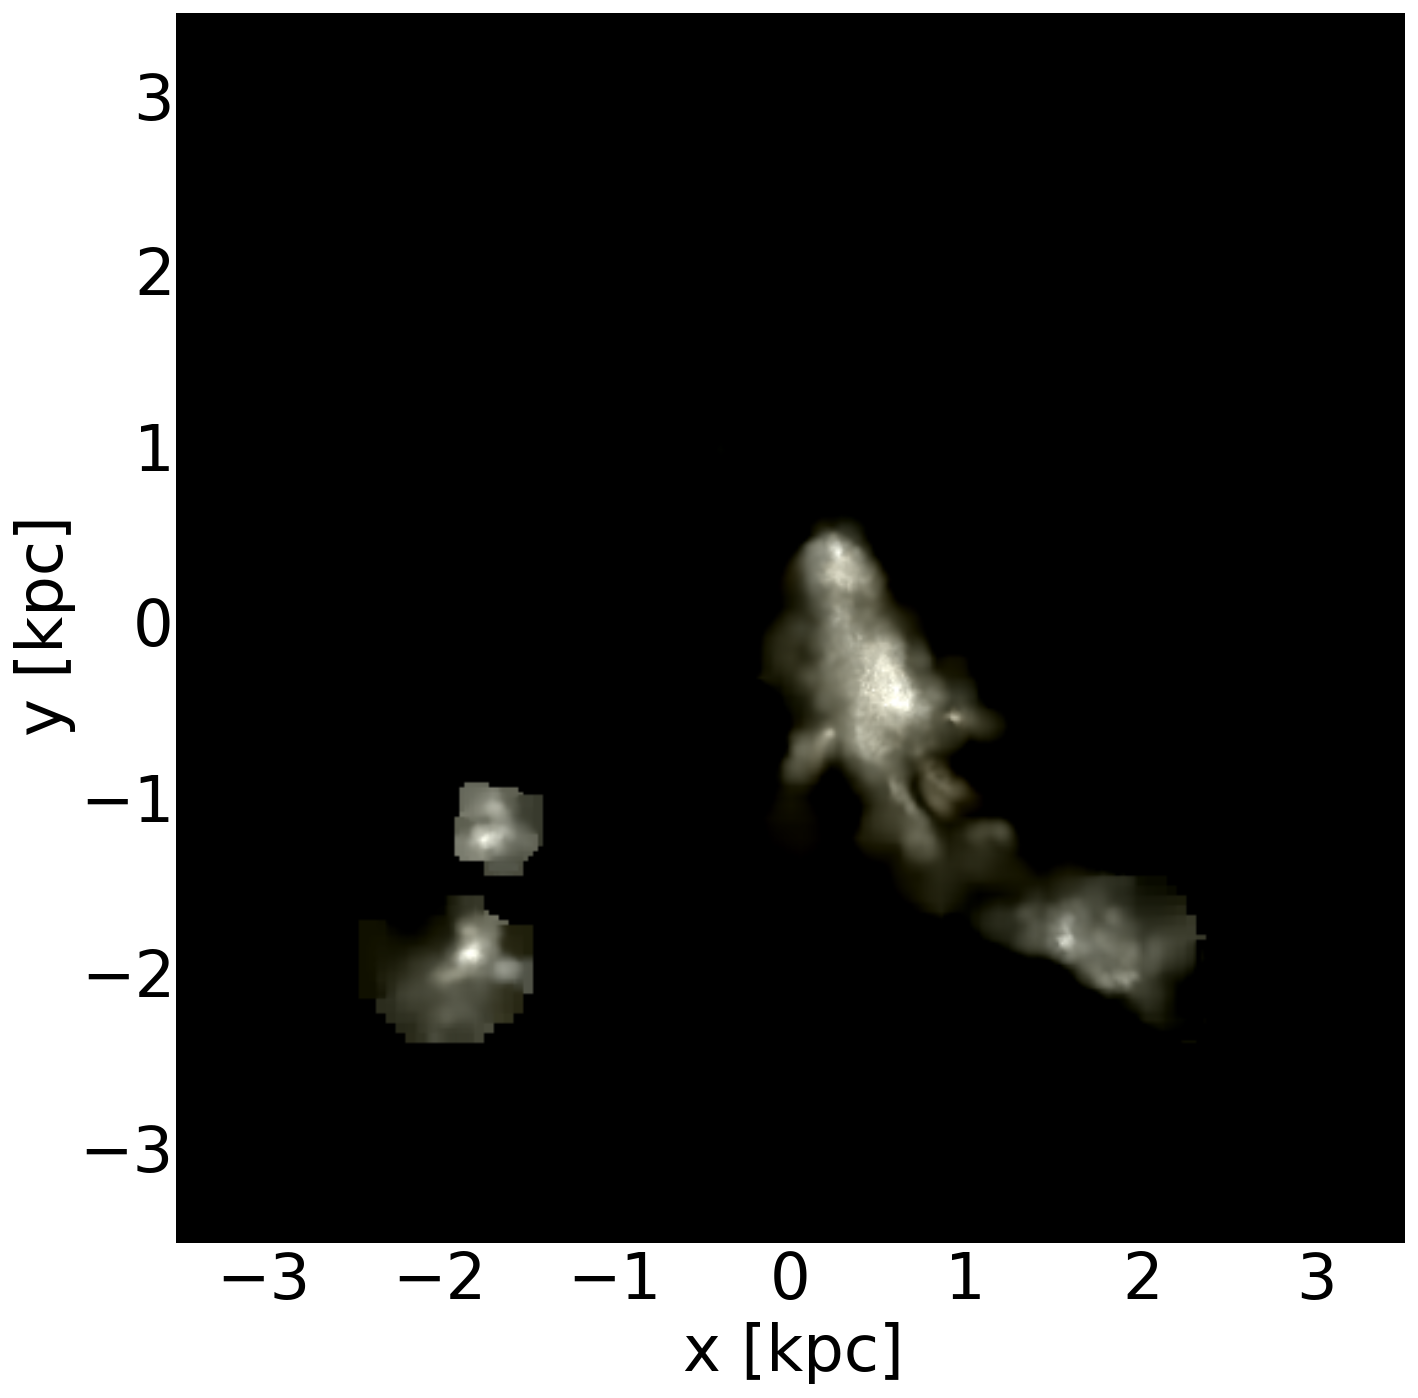

In [65]:
with pynbody.transformation.translate(large_galaxy_ss, -1*largest_halo_location):
    # L_gal = pynbody.analysis.angmom.ang_mom_vec_units(large_galaxy_ss)
    pynbody.plot.stars.render(large_galaxy_ss,width='20 kpc', dynamic_range=3)

Density - z = 9.0


/Users/earnric/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


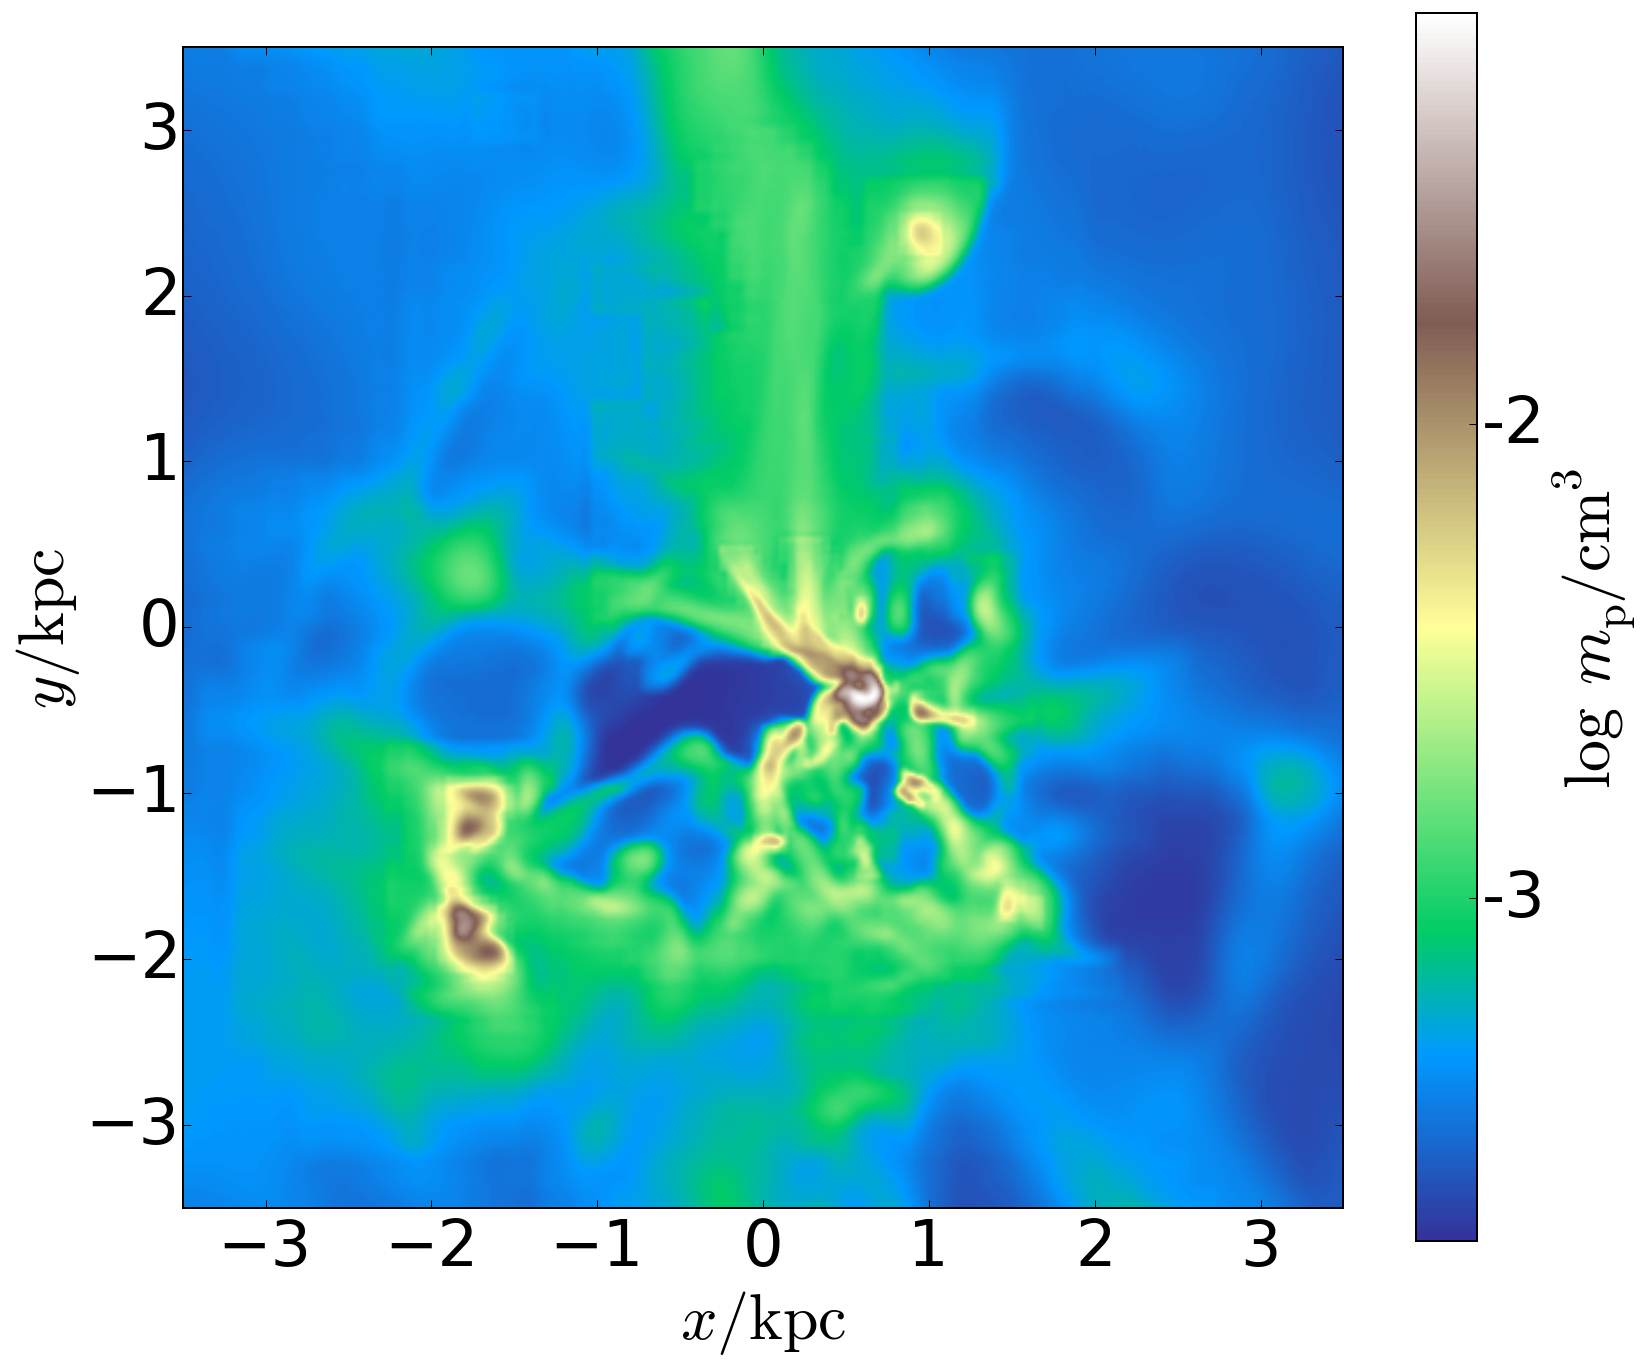

In [39]:
with pynbody.transformation.translate(large_galaxy_ss, -1*largest_halo_location):
    #pynbody.analysis.angmom.faceon(impData,cen=(0,0,0),disk_size='4 kpc')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.set_xlabel(fontsize=40)
    fileOut = "img_lrgst_halo_Density-z=%.1lf.pdf"%(z)
    sph.image(large_galaxy_ss.g,qty="rho",width='20 kpc',cmap="terrain", denoise=True ,av_z=True, units="m_p cm^-3",
                      log=True, approximate_fast=False, 
                      subplot=ax,qtytitle=r"$m_{\rm p}/{\rm cm}^{3}$"); 
    #ax.set_yticks([-tic, 0,tic])
    plt.savefig(fileOut,dpi=fig.dpi,bbox_inches='tight')
    #plt.close(fig)
    #del(ax)
    gc.collect()

In [16]:
gc.collect()

6739